In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sdeint
import pycatch22 as catch22
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from scipy.spatial import distance
import scipy.stats
import seaborn as sns
from sklearn import svm
from sklearn.manifold import TSNE
from scipy.optimize import fsolve
import pandas as pd
import matplotlib as mpl
import pickle
sns.set()

In [3]:
def gen_limitCycle(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 10, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    return ts_hopf, df

In [194]:
ts, df = gen_limitCycle(500)
normalized_features = StandardScaler().fit_transform(df.iloc[:,:22])
Z = linkage(normalized_features, method='ward')

Generating Limit Cycle Instances...


KeyboardInterrupt: 

In [4]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

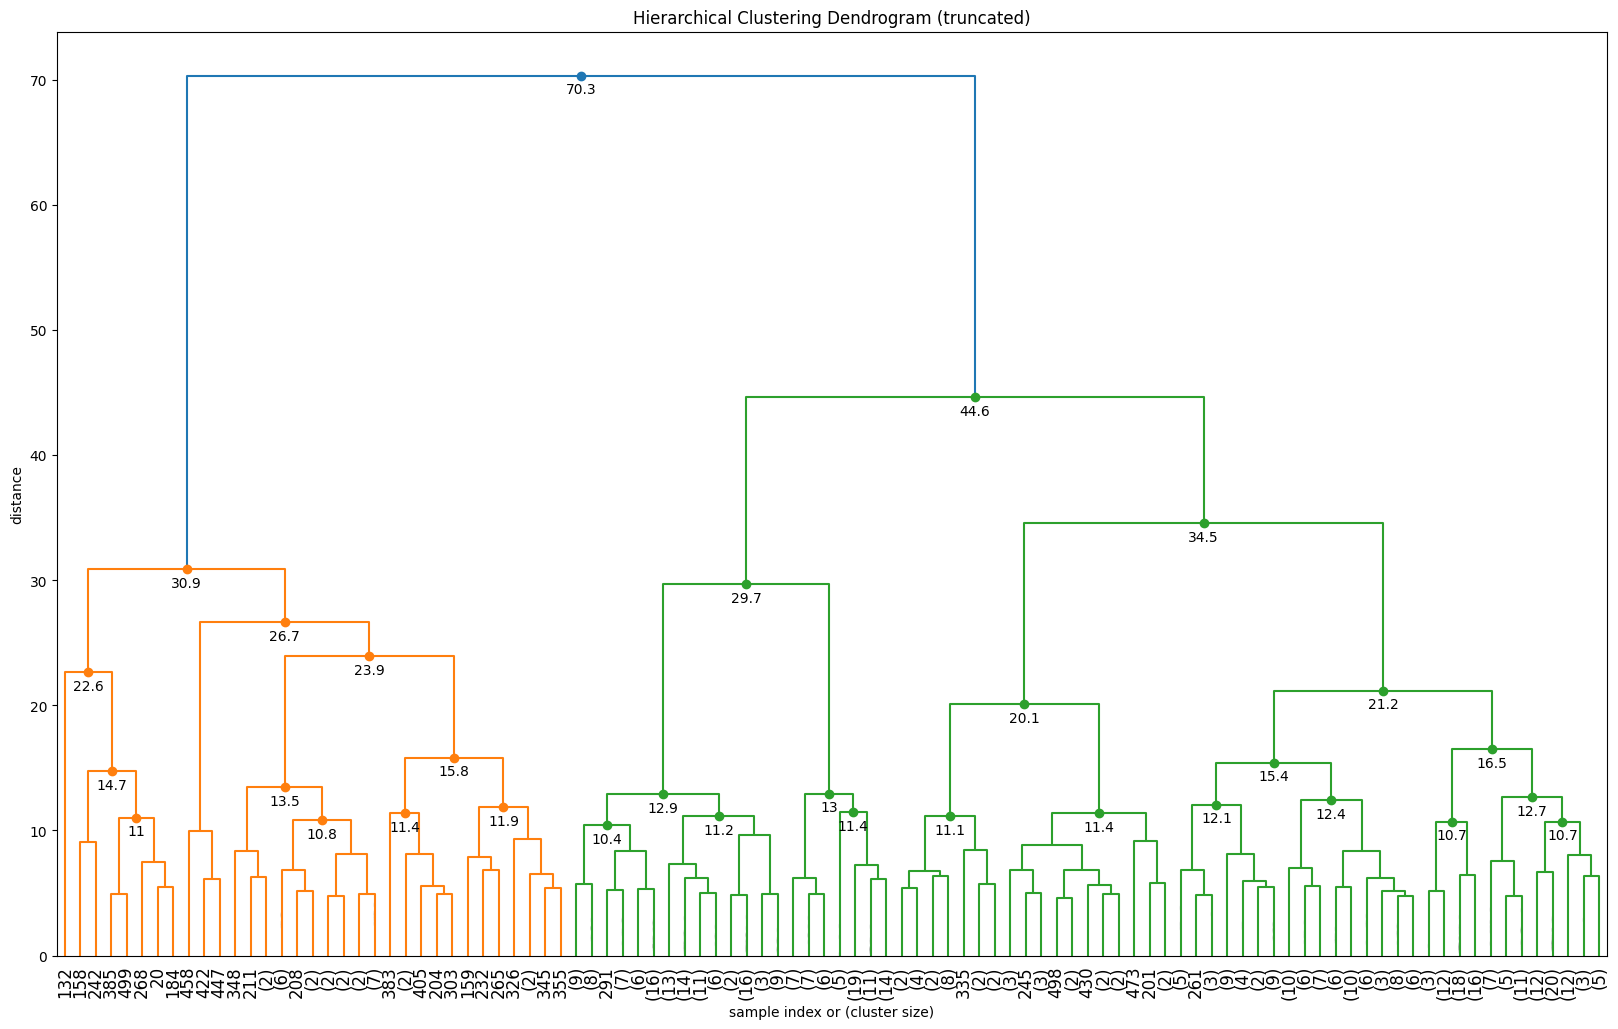

In [ ]:
plt.figure(figsize=(20,12))
fancy_dendrogram(Z, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=10)
plt.show()

In [ ]:
#dd = 0.001 # distance increment
#max_d = 0 # start at 0 and sweep up
# find optimal cutoff to obtain 100 clusters
#while True:
#    clusters = fcluster(Z, max_d, criterion='distance')
#    num_clusters = np.max(clusters)
 #   if num_clusters == 100:
 #       print(max_d)
#        break
 #   else:
 #       max_d = max_d + dd

In [ ]:
target = 100
def calc_clusters(max_d):
    clusters = fcluster(Z, max_d, criterion='distance')
    num_clusters = np.max(clusters)
    return target - num_clusters
res = fsolve(calc_clusters, x0=0.01)
clusters = fcluster(Z, res, criterion='distance')
num_clusters = np.max(clusters)

In [ ]:
# create subset of instances by selecting one instance from each cluster
# if more than one instance in cluster, find the most representative instance by minimizing euclidean distance
subset_index = list() # store indicies of the selected instances from each cluster
for i in range(1, num_clusters+1):
    cluster_indicies = np.argwhere(clusters == i).reshape(-1,) # get all samples in each cluster
    if len(cluster_indicies) > 1:
        # select the most representative instance that minimizes sum of pairwise distances
        ary = distance.cdist(df.iloc[cluster_indicies, :22], df.iloc[cluster_indicies, :22], metric='euclidean')
        most_representative = np.sum(ary, axis=1).argmin()
        most_rep_index = cluster_indicies[most_representative]
    else:
        most_rep_index = cluster_indicies.reshape(-1,)[0]
    subset_index.append(most_rep_index)

In [ ]:
# reduced ts and df for the selected subset
ts_reduced = ts[subset_index]
df_reduced = df.iloc[subset_index] # retains original index numbers

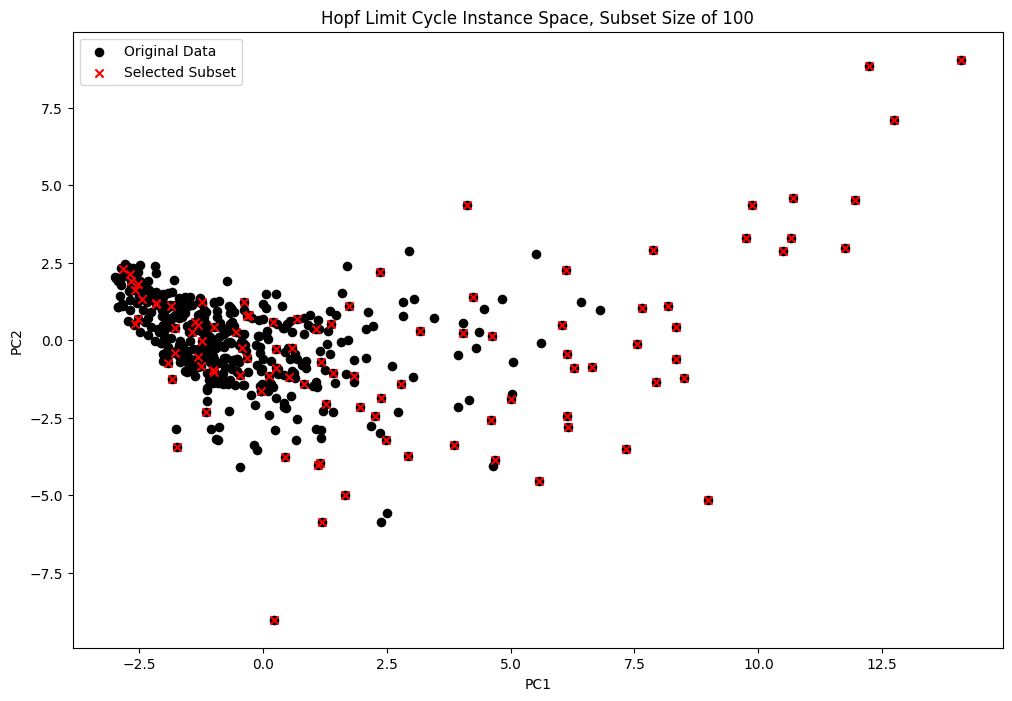

In [ ]:
plt.figure(figsize=(12,8))
pca_reduce = PCA(n_components=2).fit(normalized_features)
pca = pca_reduce.transform(normalized_features)
plt.scatter(pca[:,0], pca[:,1], s=35, c='k',label='Original Data')
plt.scatter(pca[subset_index,0], pca[subset_index,1], s=35, c='r', marker='x',label='Selected Subset')
plt.title('Hopf Limit Cycle Instance Space, Subset Size of 100')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

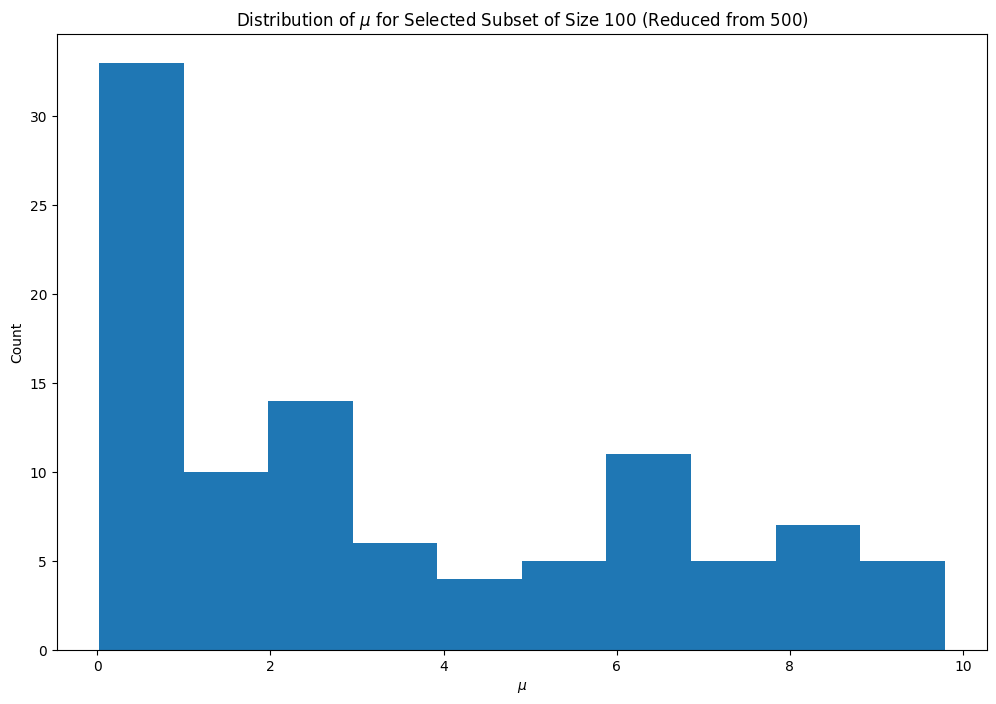

In [ ]:
# plot hist
plt.figure(figsize=(12,8))
mus = df_reduced.iloc[:, 22].to_numpy()
etas = df_reduced.iloc[:, 23].to_numpy()
plt.hist(mus)
plt.xlabel('$\mu$')
plt.ylabel('Count')
plt.title('Distribution of $\mu$ for Selected Subset of Size 100 (Reduced from 500)')
plt.show()


In [22]:
def select_representative_instances(subset_target_size, ts, df, x0, dendrogram=False):
    # takes in target number of instances, uses hierarchical clustering to find most representative samples
    # returns dataframe and ts of selected subset
    normalized_features = StandardScaler().fit_transform(df.iloc[:,:22]) # extract the features from df and standardise
    Z = linkage(normalized_features, method='ward')
    def calc_clusters(max_d):
        clusters = fcluster(Z, max_d, criterion='distance')
        num_clusters = np.max(clusters)
        return subset_target_size - num_clusters
    res = fsolve(calc_clusters, x0=x0)
    clusters = fcluster(Z, res, criterion='distance')
    num_clusters = np.max(clusters)
    subset_index = list() # store indicies of the selected instances from each cluster
    for i in range(1, num_clusters+1):
        cluster_indicies = np.argwhere(clusters == i).reshape(-1,) # get all samples in each cluster
        if len(cluster_indicies) > 1:
            # select the most representative instance that minimizes sum of pairwise distances
            ary = distance.cdist(df.iloc[cluster_indicies, :22], df.iloc[cluster_indicies, :22], metric='euclidean')
            most_representative = np.sum(ary, axis=1).argmin()
            most_rep_index = cluster_indicies[most_representative]
        else:
            most_rep_index = cluster_indicies.reshape(-1,)[0]
        subset_index.append(most_rep_index)
    # reduced ts and df for the selected subset
    ts_reduced = ts[subset_index]
    df_reduced = df.iloc[subset_index] # retains original index numbers

    # plot dendrogram with corresponding cutoff
    if dendrogram:
        plt.figure(figsize=(20,12))
        fancy_dendrogram(Z, max_d=res, truncate_mode='lastp', p=subset_target_size, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=10)
        plt.show()
    return ts_reduced, df_reduced

In [ ]:
#t,d = select_representative_instances(100, ts, df, dendrogram=False)
#subset_index = d.index.to_list() # extract index of selected subset for plotting comparison with original full dataset

In [5]:
def gen_switching(num_samples): # num samples 
    # hopf
    eta_val_bistable = np.random.uniform(0.45, 0.7, size=num_samples)
    mu_val_bistable = np.random.uniform(-0.384, 0.384, size=num_samples) # contrain sampling to the bistable region 
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Bistable Switching Instances...')
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    return ts_bistable, df

In [ ]:
ts, df = gen_switching(500)

Generating Bistable Switching Instances...


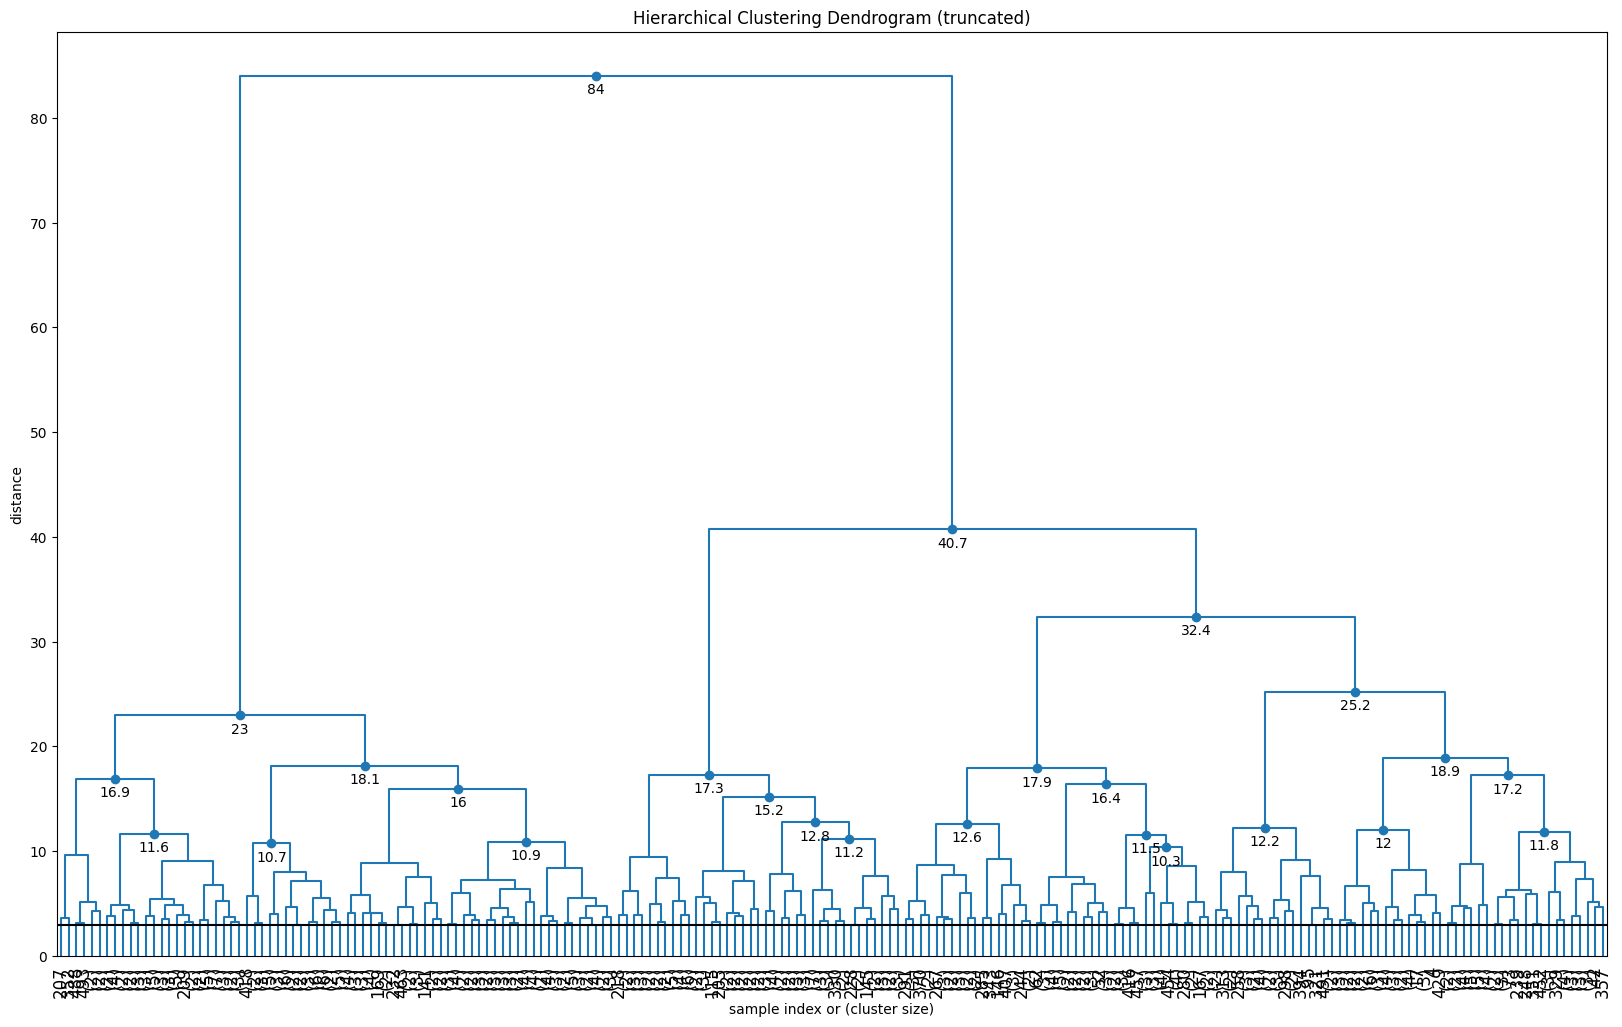

In [ ]:
ts_switch, df_switch = select_representative_instances(subset_target_size=200, ts=ts, df=df, dendrogram=True)

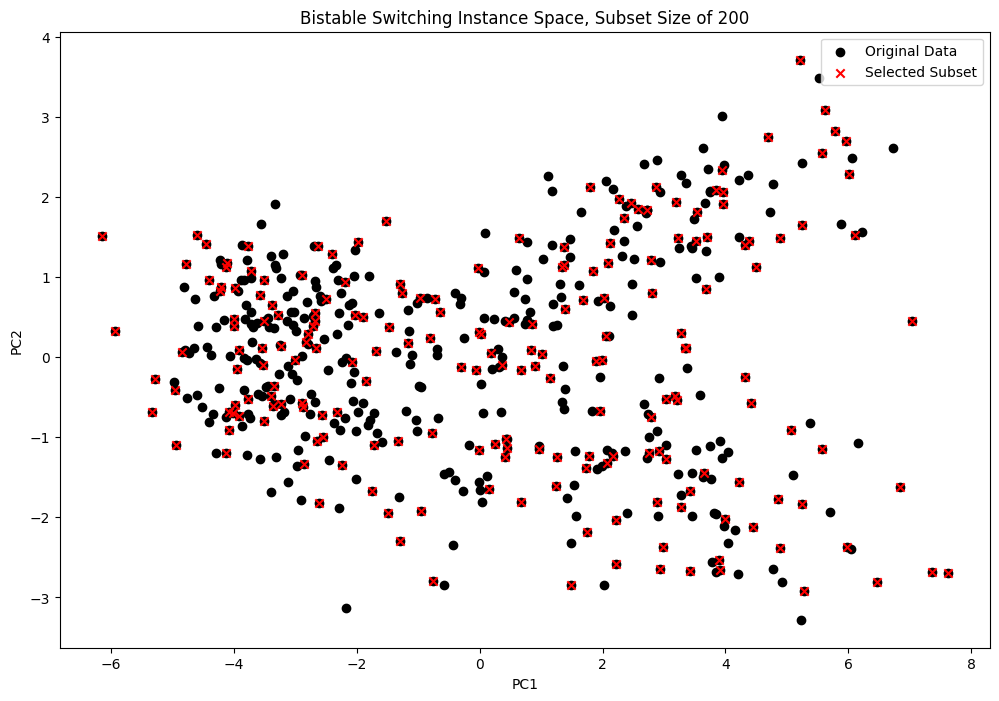

In [ ]:
normalized_features_orig = StandardScaler().fit_transform(df.iloc[:,:22])
pca = PCA(n_components=2).fit_transform(normalized_features_orig)
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c='k', label='Original Data')
plt.scatter(pca[df_switch.index.to_list(),0], pca[df_switch.index.to_list(),1], c='r', marker='x', label='Selected Subset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Bistable Switching Instance Space, Subset Size of 200')
plt.legend()
plt.show()

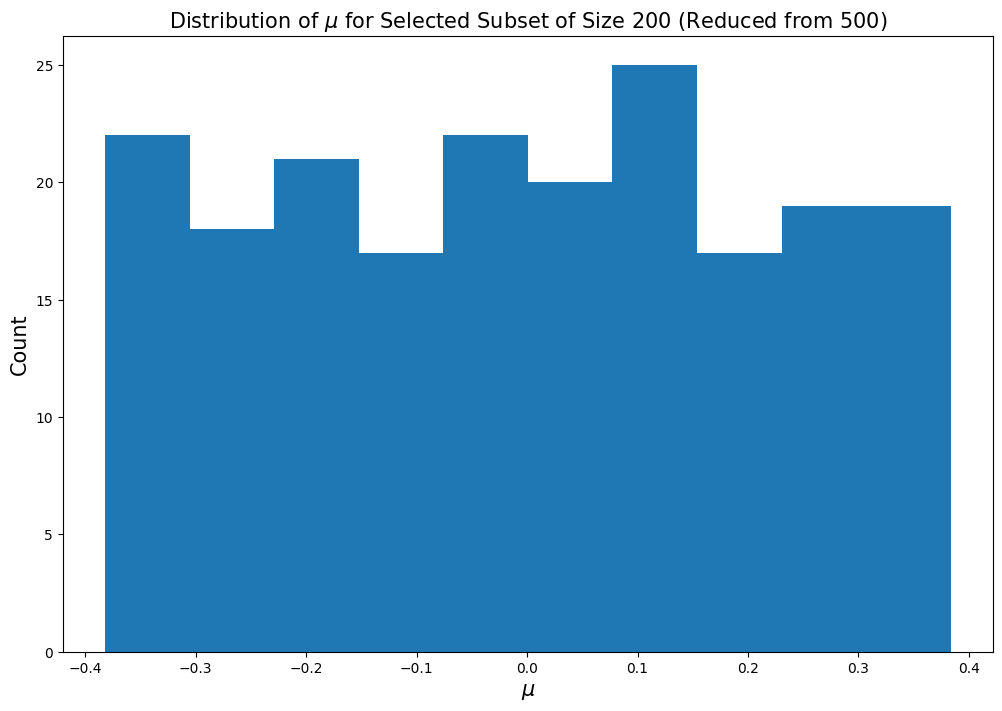

In [ ]:
# plot hist
plt.figure(figsize=(12,8))
mus = df_switch.iloc[:, 22].to_numpy()
etas = df_switch.iloc[:, 23].to_numpy()
plt.hist(mus)
plt.xlabel('$\mu$', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of $\mu$ for Selected Subset of Size 200 (Reduced from 500)', fontsize=15)
plt.show()

In [6]:
def gen_fixedpoint(num_samples):
    
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.1, 0.7, size=num_samples)
    mu_val_hookes = np.random.uniform(-10, -0.1, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (1/3)...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['system'] = 'Hookes'

    # system 2 - hopf 
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(-10, -0.01, size=num_samples) # sample 
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (2/3)...')
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['system'] = 'Hopf'

    # system 3 - bistable
    eta_val_bistable = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_bistable = np.concatenate([np.random.uniform(-10, -0.5, size=int(num_samples/2)), np.random.uniform(0.5, 10, size=int(num_samples/2))])
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances (3/3)...')
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['system'] = 'Bistable'

    ts_fixedpt = np.vstack([ts_hookes, ts_hopf, ts_bistable])
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable])


    return ts_fixedpt, df_fixedpt
    

In [ ]:
ts_fp, df_fp = gen_fixedpoint(500)

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...


KeyboardInterrupt: 

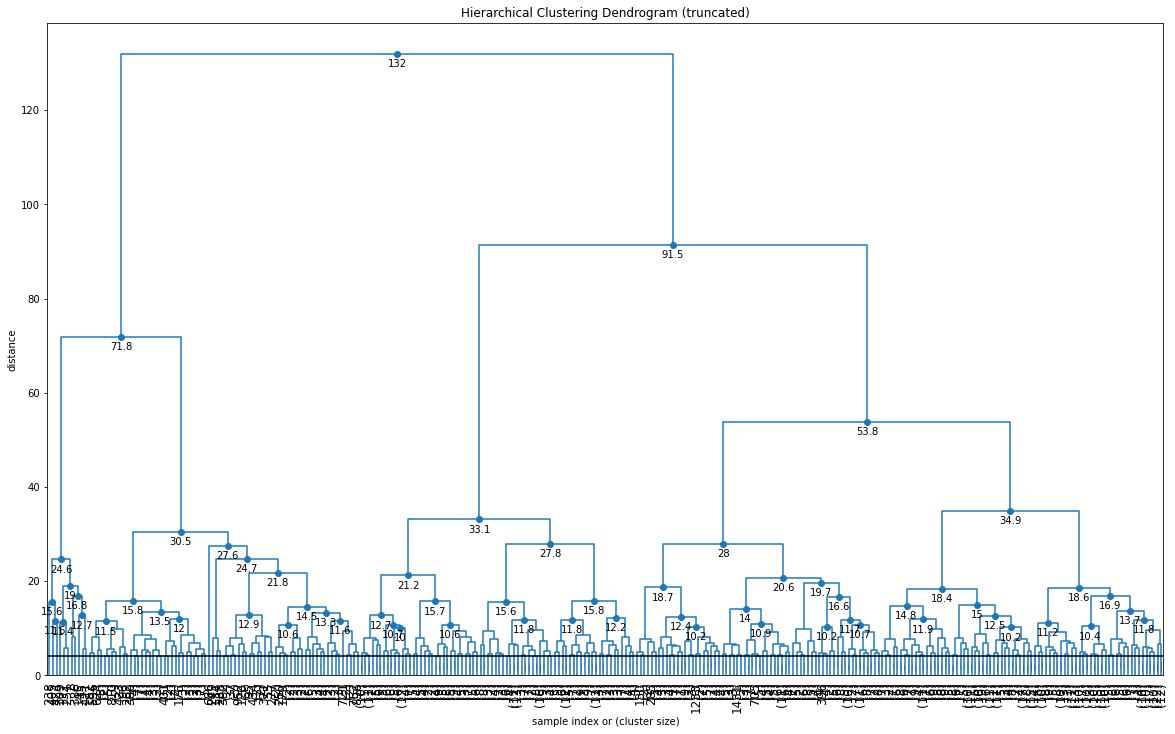

In [ ]:
ts_fp_reduced, df_fp_reduced = select_representative_instances(subset_target_size=300, ts=ts_fp, df=df_fp, dendrogram=True)

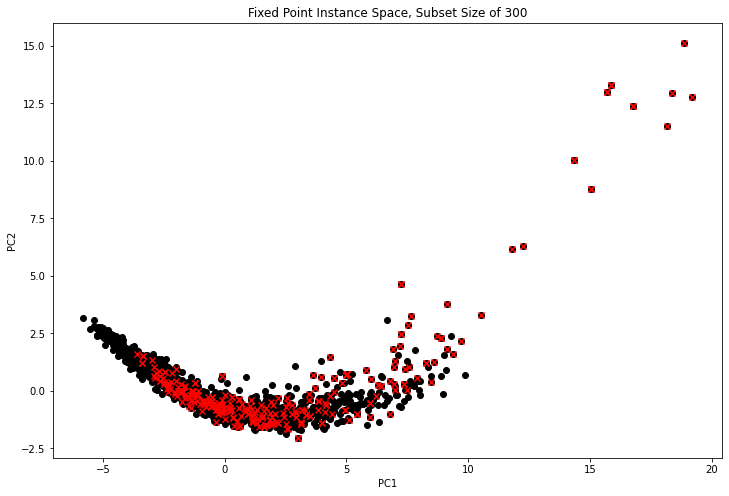

In [ ]:
norm_feat = StandardScaler().fit_transform(df_fp.iloc[:,:22])
pca = PCA(n_components=2).fit_transform(norm_feat)
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c='k', label='Original Data')
plt.scatter(pca[df_fp_reduced.index.to_list(),0], pca[df_fp_reduced.index.to_list(),1], c='r', marker='x', label='Selected Subset')
plt.title('Fixed Point Instance Space, Subset Size of 300')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [7]:
ts_fp, df_fp = gen_fixedpoint(50)
ts_lc, df_lc = gen_limitCycle(50)
ts_sw, df_sw = gen_switching(50)

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...
Generating Limit Cycle Instances...
Generating Bistable Switching Instances...


In [202]:
ts_fp_red, df_fp_red = select_representative_instances(subset_target_size=30, ts=ts_fp, df=df_fp)
ts_lc_red, df_lc_red = select_representative_instances(subset_target_size=30, ts=ts_lc, df=df_lc)
ts_sw_red, df_sw_red = select_representative_instances(subset_target_size=30, ts=ts_sw, df=df_sw)

/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [206]:
test = pd.concat([df_fp_red, df_lc_red, df_sw_red])

In [210]:
rs = RobustScaler().fit(test.iloc[:,:22])
rs_fit = rs.transform(test.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1})
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)
pca_red = PCA(n_components=2).fit(mm_fit)
pca = pca_red.transform(mm_fit)

In [208]:
pca.shape

(1499, 2)

In [4]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca[:500,0], y= pca[:500,1], label="Fixed Point")
sns.scatterplot(x=pca[500:1000, 0], y=pca[500:1000, 1], label='Limit Cycle')
sns.scatter(x=pca[1000:, 0], y= pca[1000:, 1], label='Bistable Switching')


NameError: name 'pca' is not defined

<Figure size 1200x800 with 0 Axes>

In [7]:
def gen_switching(num_samples): # num samples 
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Loading Filter...')
    loaded_model = pickle.load(open('svm_model.sav', 'rb'))
    loaded_scaler = pickle.load(open('scaler_switching.sav', 'rb'))
    print('Generating Bistable Switching Instances...')
    for i in range(num_samples):
        # run loop until switching instance is generated
        while True:
            mu = np.random.uniform(-0.384, 0.384)
            eta = np.random.uniform(0.2, 1)
            def f(state, t):
                x = state
                dxdt = mu + x - x**3
                return dxdt
            ic = np.array([np.random.uniform()])
            gw = lambda y, t: eta * np.identity(ic.shape[0])
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            features = np.array(catch22.catch22_all(sol[500:])['values']).reshape(1,-1)
            if loaded_model.predict(loaded_scaler.transform(features)) == 1:
                break
        eta_val_bistable.append(eta)
        mu_val_bistable.append(mu)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    return ts_bistable, df

In [91]:
ts_fp, df_fp = gen_fixedpoint(1000)
ts_lc, df_lc = gen_limitCycle(1000)
ts_sw, df_sw = gen_switching(1000)

Generating Fixed Point Instances (1/3)...
Generating Fixed Point Instances (2/3)...
Generating Fixed Point Instances (3/3)...
Generating Limit Cycle Instances...
Loading Filter...
Generating Bistable Switching Instances...


In [102]:
ts_sw_reduced, df_sw_reduced = select_representative_instances(subset_target_size=500, ts=ts_sw, df=df_sw, x0=0.1, dendrogram=False)
ts_fp_reduced, df_fp_reduced = select_representative_instances(subset_target_size=500, ts=ts_fp, df=df_fp,  x0=0.2, dendrogram=False)
ts_lc_reduced, df_lc_reduced = select_representative_instances(subset_target_size=500, ts=ts_lc, df=df_lc,  x0=0.1, dendrogram=False)

In [103]:
combined = pd.concat([df_sw_reduced, df_fp_reduced, df_lc_reduced])

In [104]:
scaler = StandardScaler().fit(combined.iloc[:, :22])
scaled = scaler.transform(combined.iloc[:, :22])

In [105]:
pca_transformer = PCA(n_components = 2).fit(scaled)
pca = pca_transformer.transform(scaled)

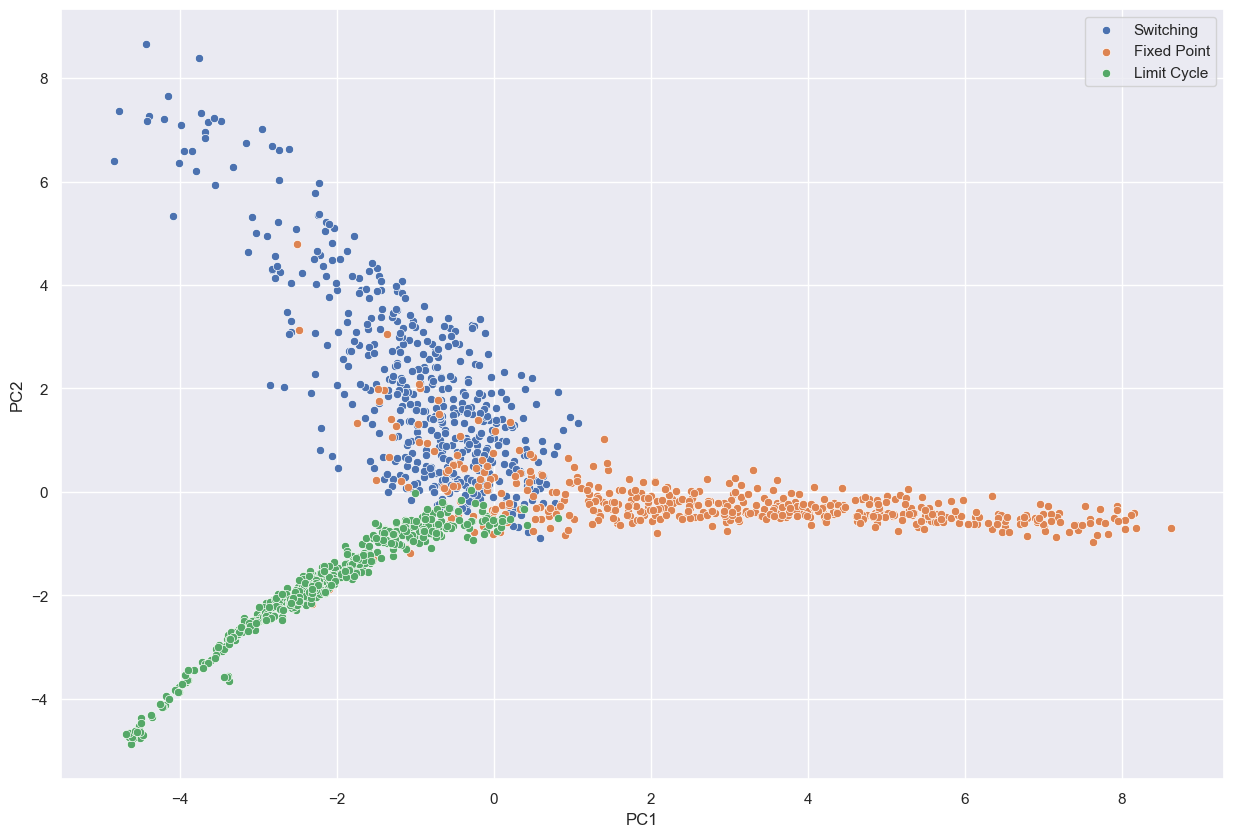

In [109]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=pca[:500, 0], y=pca[:500, 1], label='Switching')
sns.scatterplot(x=pca[500:1000, 0], y=pca[500:1000, 1], label='Fixed Point')
sns.scatterplot(x=pca[1000:, 0], y=pca[1000:, 1], label='Limit Cycle')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [126]:
def MixedSigmoid(x, doScale):
    # use a scaled sigmoid if iqr=0, robust sigmoid otherwise
    medianX = np.median(x)
    iqrX = scipy.stats.iqr(x)
    
    # if iqr is zero, do a standard sigmoid transformation
    if iqrX == 0:
        meanX = np.mean(x)
        stdX = np.std(x)
        xhat = 1/(1+np.exp(-(x-meanX)/stdX))
        xhat = xhat.to_numpy()
        if doScale:
            # rescale to unit interval
            xhat = MinMaxScaler(feature_range=(0,1)).fit_transform(xhat)

    # else do robust sigmoid
    else:
        xhat = 1/(1 + np.exp(-(x-medianX)/(iqrX/1.35)))
        xhat = xhat.to_numpy()
        if doScale:
            # linearly rescale data to unit interval
            xhat = MinMaxScaler(feature_range=(0,1)).fit_transform(xhat)

    return xhat


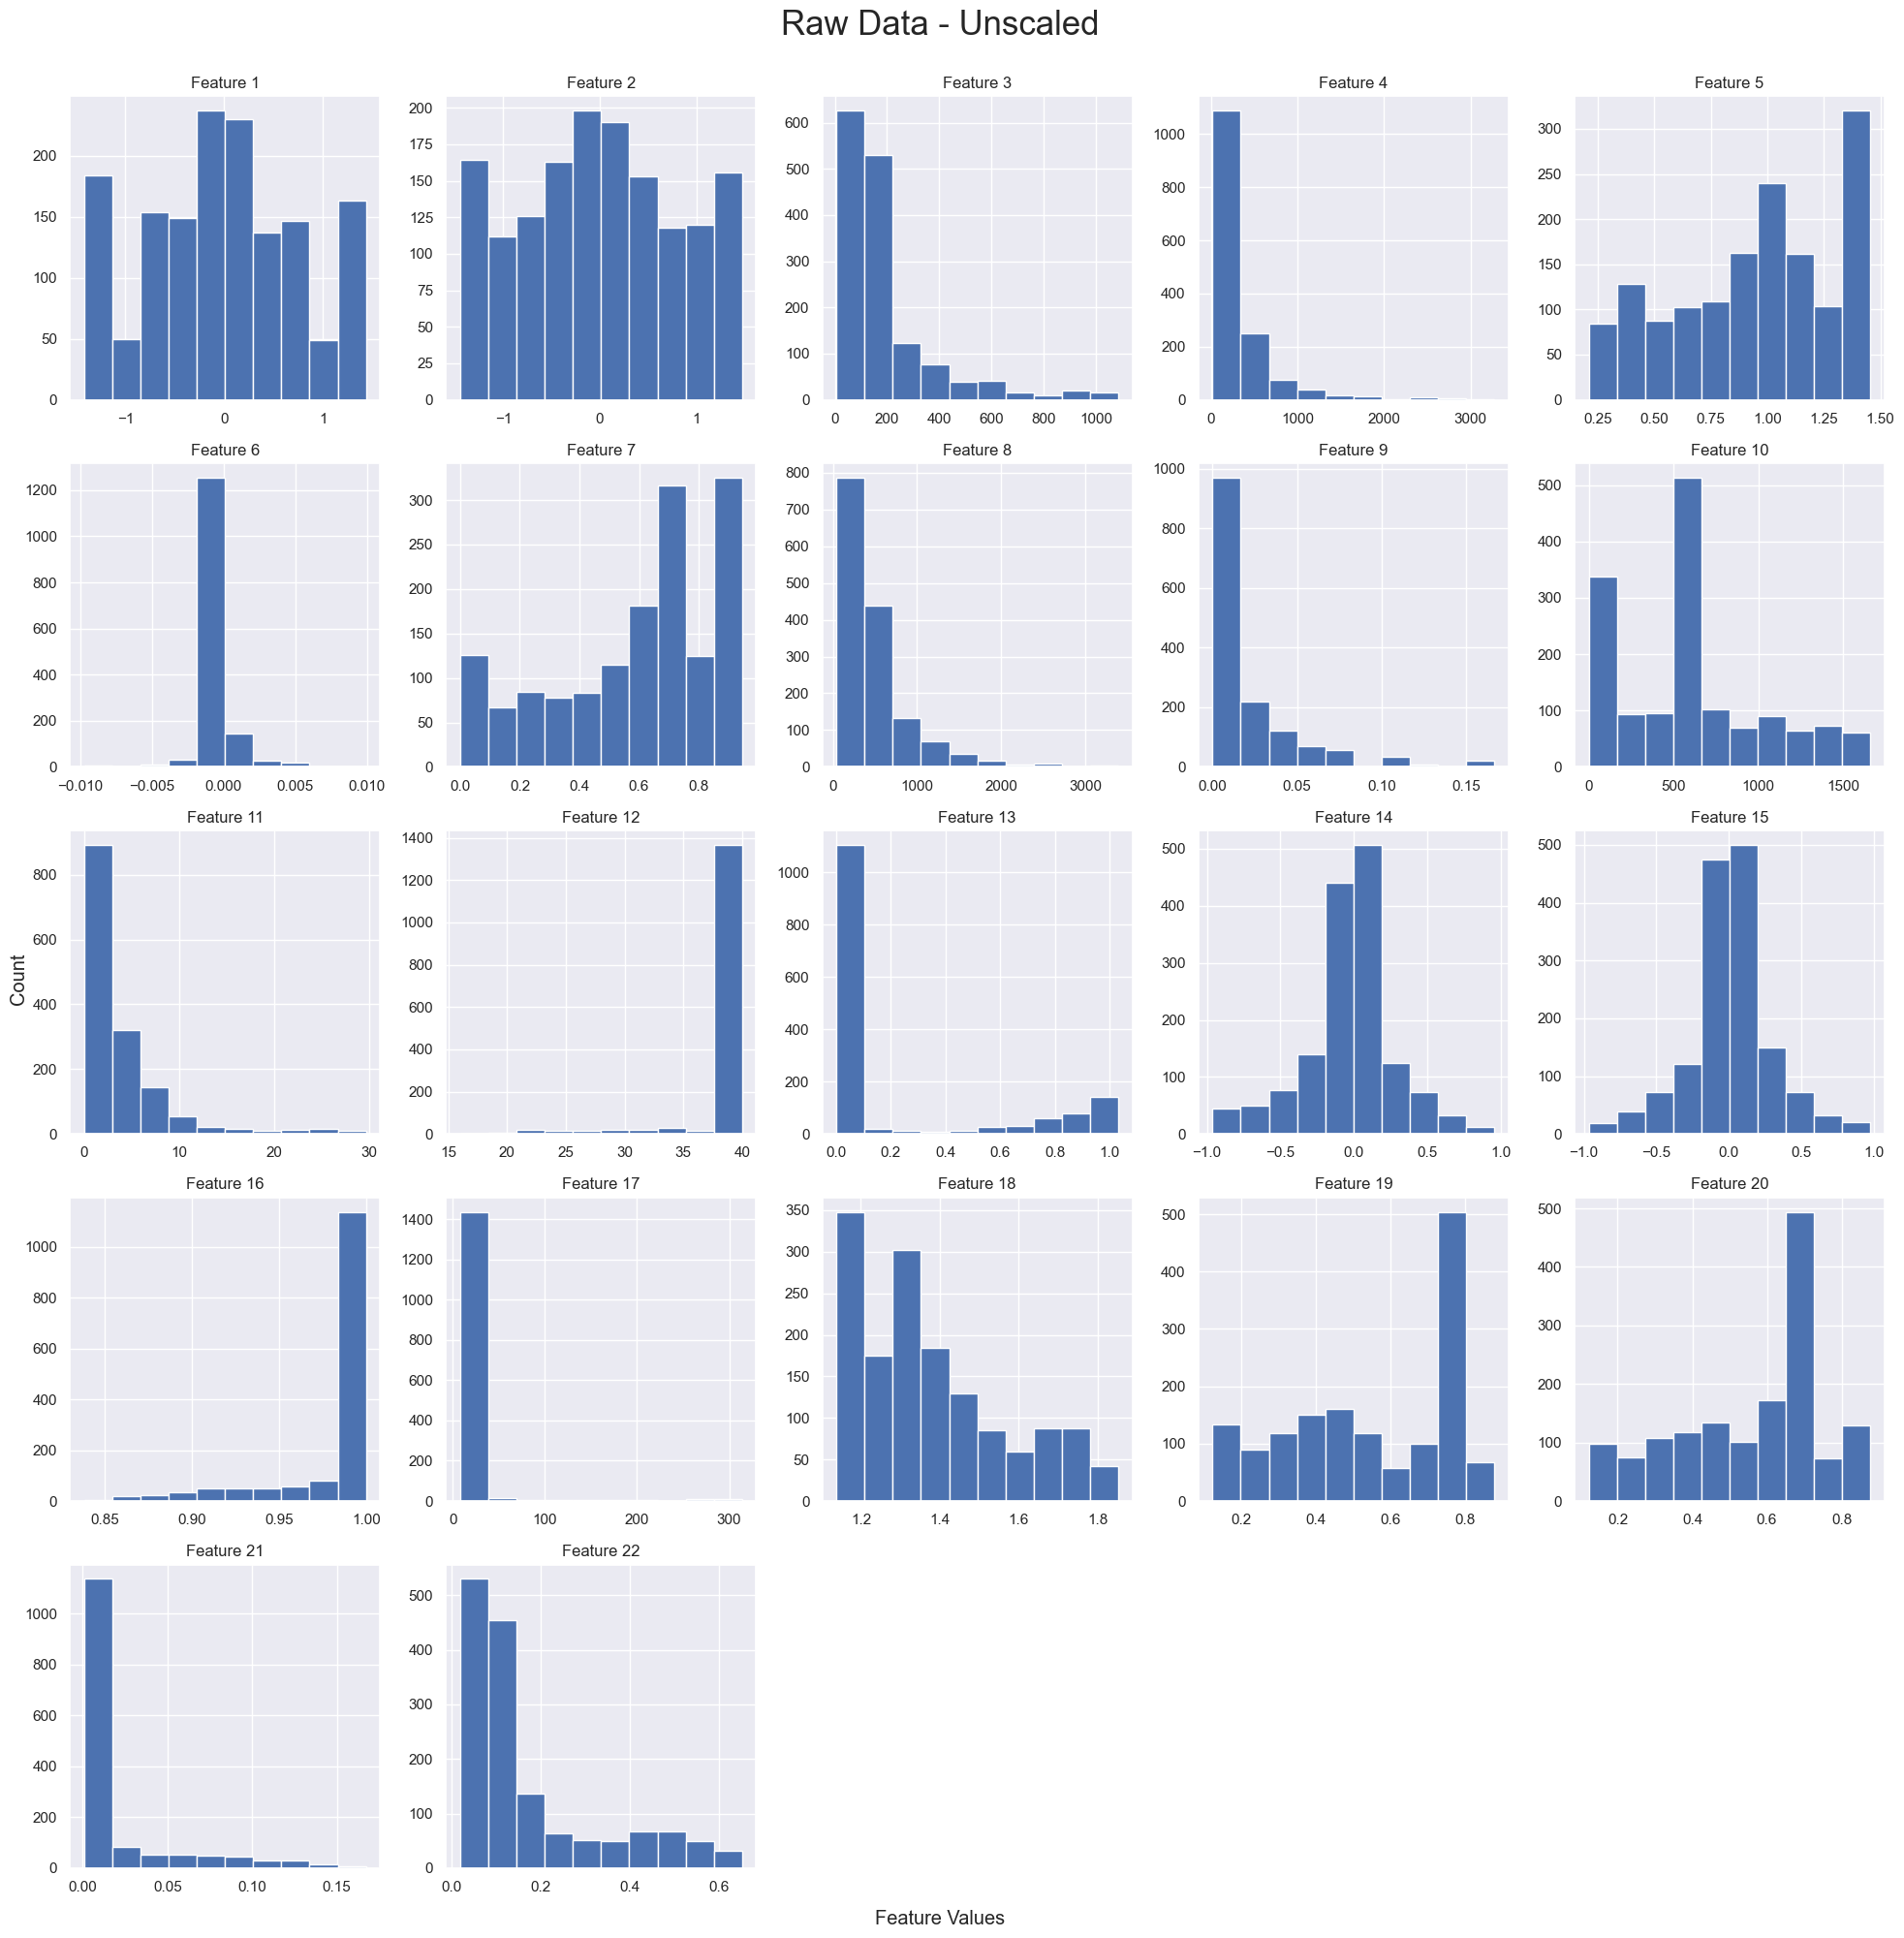

In [111]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Raw Data - Unscaled', fontsize=25, y=1)
fig.supxlabel('Feature Values')
fig.supylabel('Count')
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.set_visible(False)
    else:
        ax.hist(combined.iloc[:,index])
        ax.set_title(f'Feature {index+1}')
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.tight_layout()
plt.show()

In [123]:
scaled = MixedSigmoid(combined.iloc[:,:22], doScale=True)

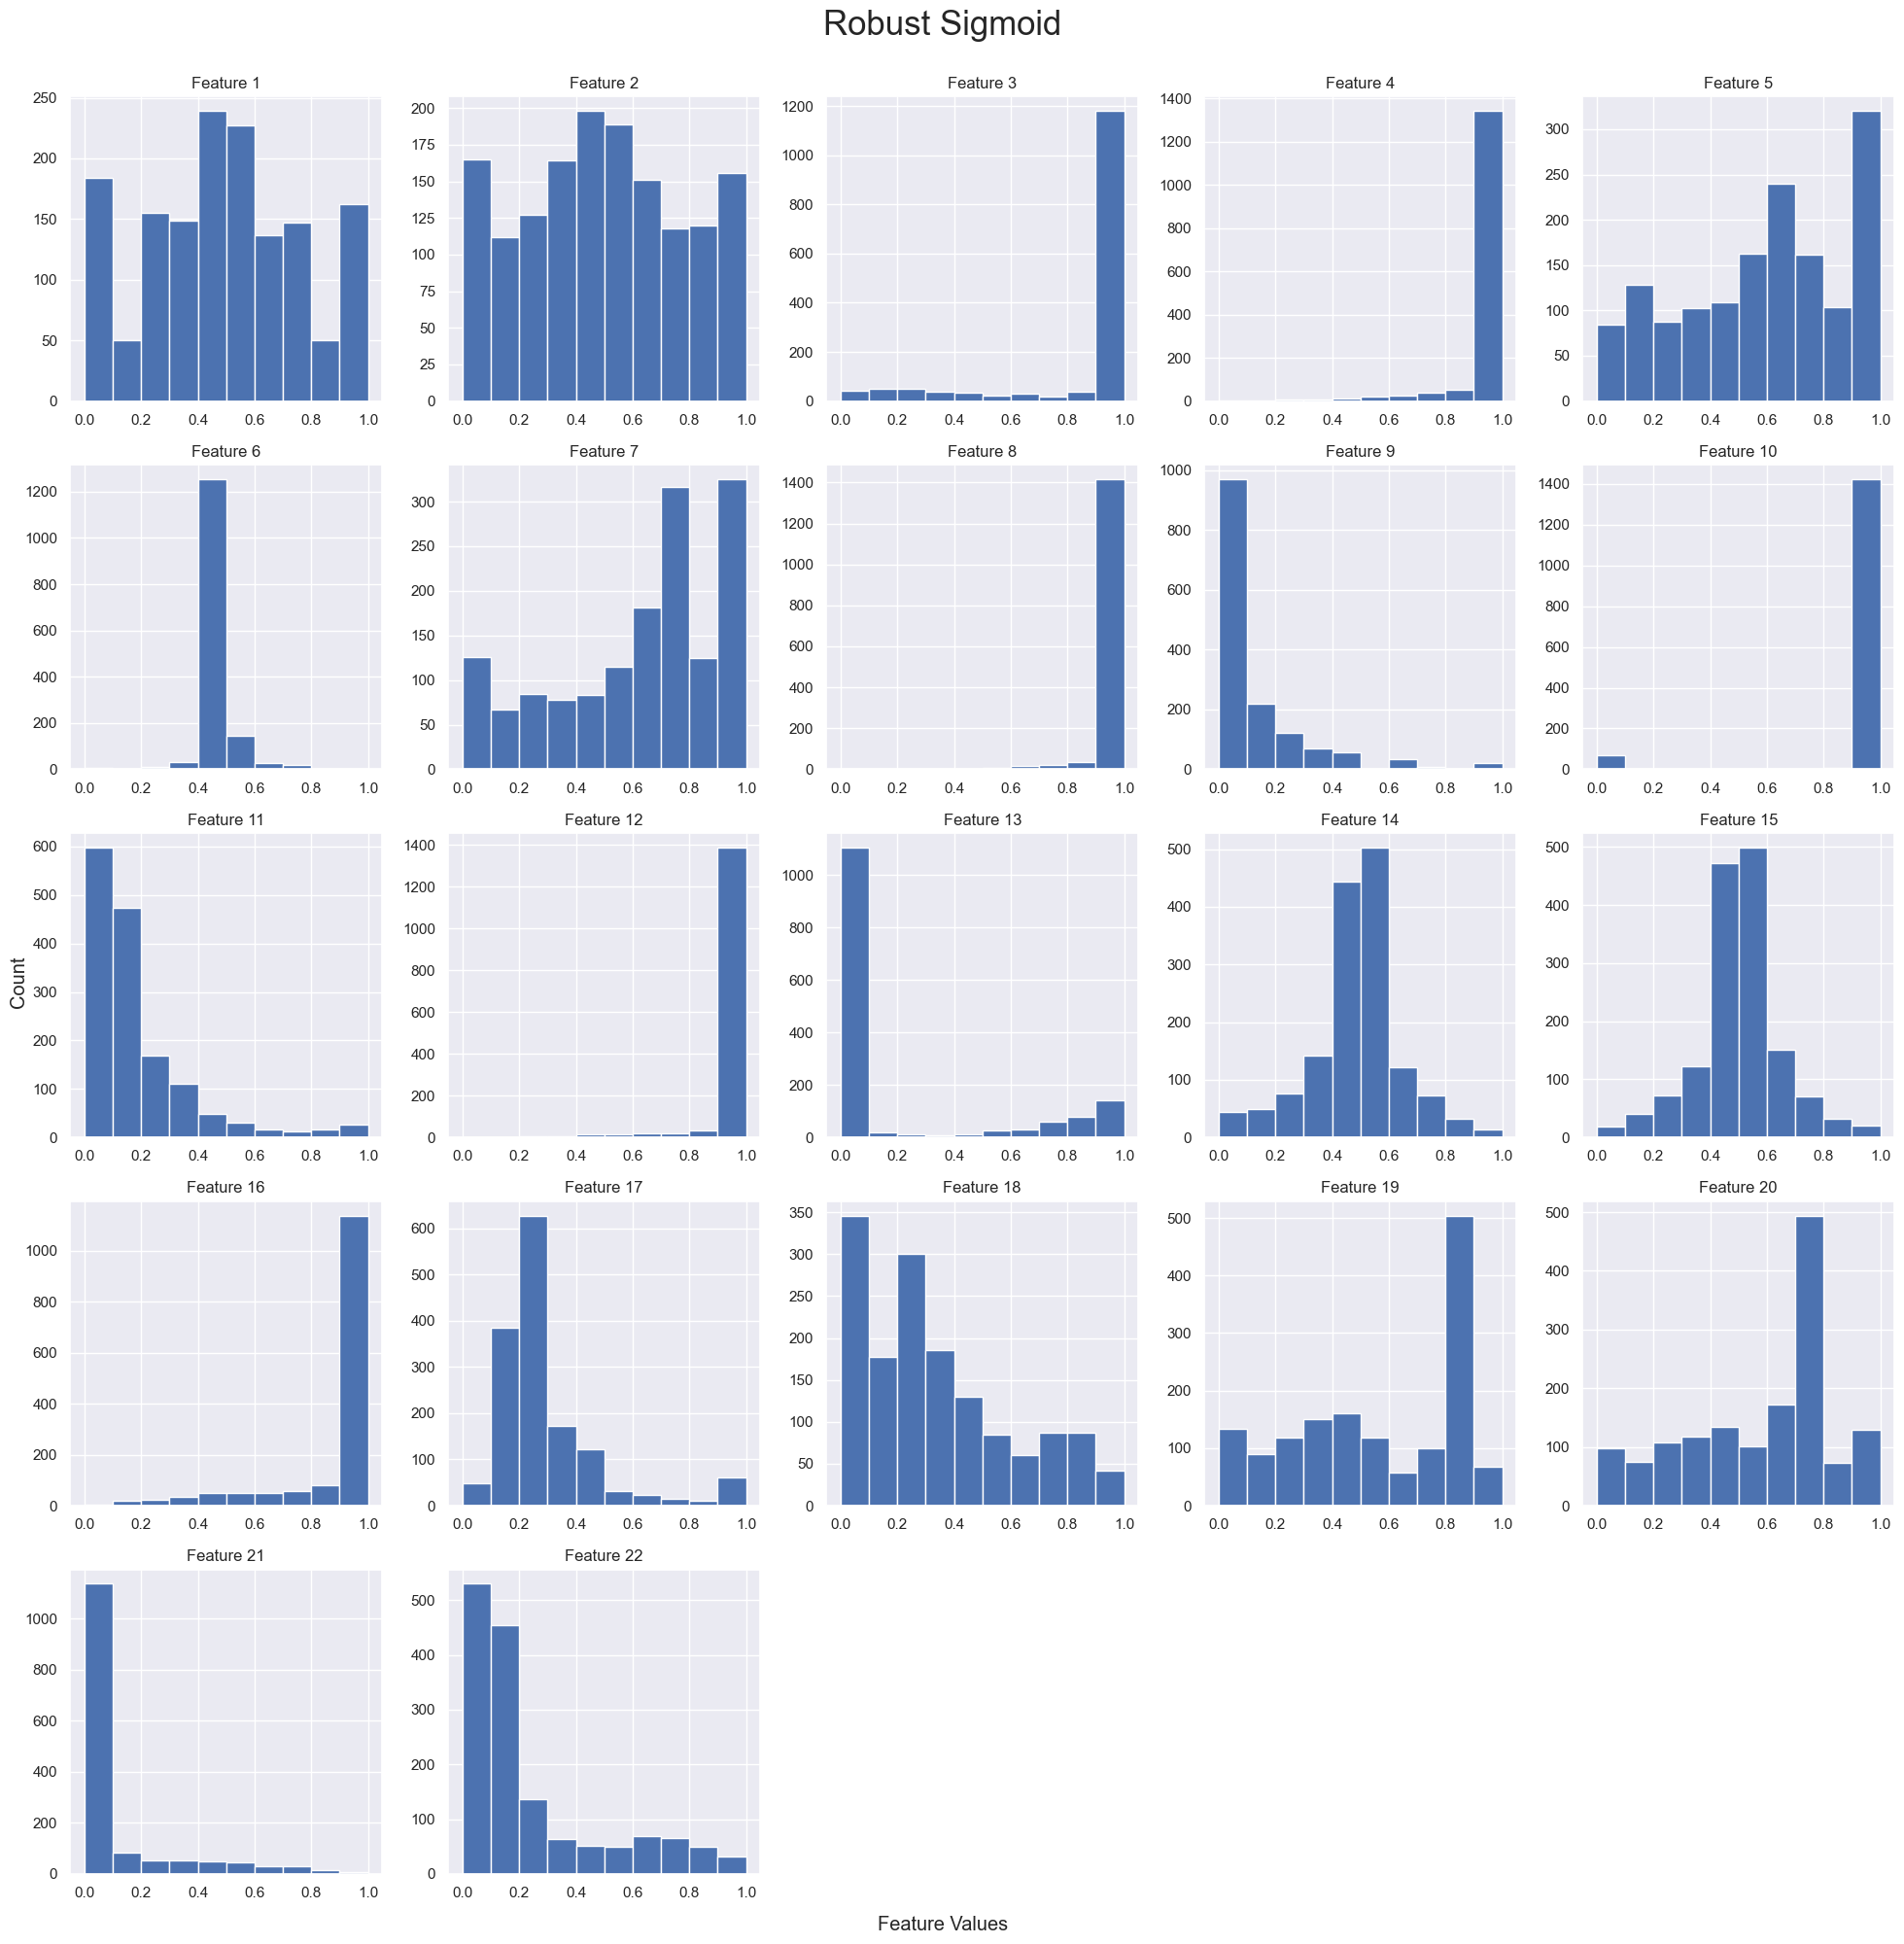

In [124]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Robust Sigmoid', fontsize=25, y=1)
fig.supxlabel('Feature Values')
fig.supylabel('Count')
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.set_visible(False)
    else:
        ax.hist(scaled[:,index])
        ax.set_title(f'Feature {index+1}')
        ax.set_xlabel('')
        ax.set_ylabel('')
fig.tight_layout()
plt.show()

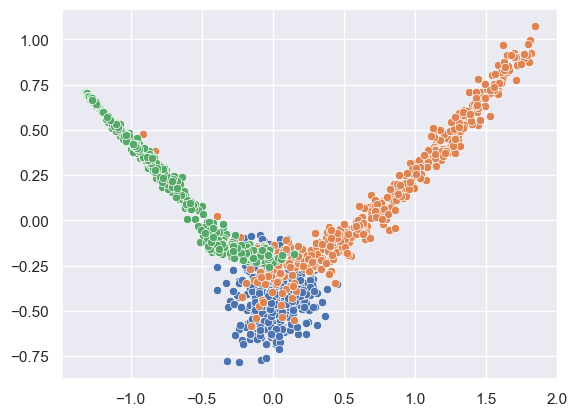

In [125]:
pca = PCA(n_components=2).fit_transform(scaled)
sns.scatterplot(x=pca[:500,0], y=pca[:500,1])
sns.scatterplot(x=pca[500:1000,0], y=pca[500:1000,1])
sns.scatterplot(x=pca[1000:, 0], y=pca[1000:,1])
plt.show()